This notebook shows the reconstruction of a 3D GRE with two almost identical echotimes sampled with 3D Lissajous variable density shell trajectories.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

sys.path.insert(0, "../src")

import torch
import zarr

from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.recon.sense import SENSE
from juart.vis.interactive import InteractiveFigure3D

# Load preprocessed dataset

In [2]:
device = "cuda:2"

store = zarr.storage.LocalStore(
    "/home/jovyan/datasets/num_phantom_128_R1/",
)
group = zarr.open_group(store, mode="r")
k = group["k"][:]
C = group["C"][:]
d = group["d"][:]

# Convert data to JUART format

In [3]:
# Scale trajectory to [-0.5, 0.5]
print(f"Min/Max of trajectory: {k.min()} / {k.max()}")
k = k / (2 * k.max())
print(f"Min/Max of trajectory: {k.min()} / {k.max()}")

k = torch.from_numpy(k)
C = torch.from_numpy(C)
d = torch.from_numpy(d)

Min/Max of trajectory: -0.5 / 0.5
Min/Max of trajectory: -0.5 / 0.5


# Perform 3D CG-SENSE reconstruction

In [4]:
kspace_mask = torch.randint(0, 2, (1, k.shape[1]))
k_masked = k * kspace_mask
kspace_mask.shape, k_masked.shape, d.shape, C.shape

(torch.Size([1, 2097152]),
 torch.Size([3, 2097152]),
 torch.Size([8, 2097152]),
 torch.Size([8, 128, 128, 128]))

In [5]:
AHd = nonuniform_fourier_transform_adjoint(
    k_masked[..., None, None], d[..., None, None], (128, 128, 128)
)
AHd = torch.sum(torch.conj(C[..., None, None]) * AHd, dim=0, keepdim=True)

In [6]:
H = nonuniform_transfer_function(
    k * kspace_mask, (1, 128, 128, 128), oversampling=(2, 2, 2)
)

In [7]:
C.shape, AHd.shape, H.shape

(torch.Size([8, 128, 128, 128]),
 torch.Size([1, 128, 128, 128, 1, 1]),
 torch.Size([1, 256, 256, 256]))

In [8]:
C.dtype, AHd.dtype, H.dtype

(torch.complex64, torch.complex64, torch.complex64)

In [9]:
cg_solver = SENSE(
    C[..., None].to(device),
    AHd.to(device),
    H[..., None, None].to(device),
    axes=(1, 2, 3),
    maxiter=200,
    verbose=True,
    device=device,
)

In [10]:
shape = (128, 128, 128)

In [11]:
cg_image = cg_solver.solve().view(torch.complex64).reshape(shape)

[CG] Iter: 200 Res: 6.46E+06 : 100%|██████████| 200/200 [00:08<00:00, 23.73it/s]


interactive(children=(IntSlider(value=64, description='Dimension 3', max=128, min=1), Output()), _dom_classes=…

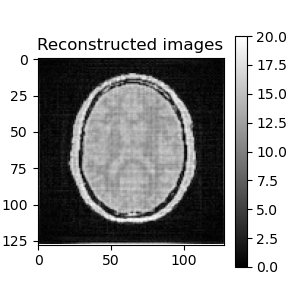

In [12]:
InteractiveFigure3D(
    torch.abs(cg_image).cpu().numpy(),
    vmin=0,
    vmax=20,
    title="Reconstructed images",
    cmap="gray",
).interactive

In [13]:
cg_image.shape

torch.Size([128, 128, 128])